In [1]:
# 1

###### 19 September 2023 #########
# In this notebook, I am making a comparison between the
# co-add spectrum and its constituents for PID 16060,
# which observed Zeta Ophiuchus and, according to Kate,
# is subject to a "REPEATOBS" that needs checking out.
#
# Looks like the observations are all STIS,
# with the E240M grating.
#
# There are only three files in the "products" directory,
# with two visit-level co-added spectra and one overall
# program-level co-added spectrum.
#
# There are 13 base-level constituent spectra in the "base"
# directory, so I'll have to see how many go into which
# of the visit-level co-adds (and what was repeated).
#
# Since this is an echelle grating, I'll have to be
# careful about how I plot the spectra.


In [2]:
# 2

# Load the relevant packages:

import numpy as np
import matplotlib.pyplot as plt
import scipy
from astropy.io import fits
from scipy import signal
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.stats import chi2_contingency
from sklearn import preprocessing
import pandas as pd
import os

from matplotlib import rc
rc('text', usetex=True)


In [3]:
# 3

# Plot the co-add spectra.
#
# Set the path to the co-add spectrum's directory
# as well as to the files themselves.

coadd_path = '/ifs/archive/dev/processing/hla/home/mburger/hasp/results_2023-09-14/16060/products/'

# Here's the overall Ppogram-level spectrum of zeta oph:

zetaoph_coadd_file = 'hst_16060_stis_-zet-oph_e140m_oe8s_cspec.fits'

# Here are the two visit-level co-added spetra:

zetaoph_STIS_E140M_const_file1 = 'hst_16060_stis_-zet-oph_e140m_oe8s01_cspec.fits'
zetaoph_STIS_E140M_const_file2 = 'hst_16060_stis_-zet-oph_e140m_oe8s04_cspec.fits'


These are the constituent files for zetaoph_1:  ['oe8s01010_x1d.fits' 'oe8s01010_x1d.fits' 'oe8s01010_x1d.fits']

Number of co-add files:  3

These are the constituent files for zetaoph_2:  ['oe8s04010_x1d.fits' 'oe8s04010_x1d.fits' 'oe8s04010_x1d.fits'
 'oe8s04020_x1d.fits' 'oe8s04020_x1d.fits' 'oe8s04020_x1d.fits'
 'oe8s04020_x1d.fits' 'oe8s04030_x1d.fits' 'oe8s04030_x1d.fits'
 'oe8s04030_x1d.fits' 'oe8s04030_x1d.fits']

Number of co-add files:  11

These are the constituent files for zetaoph:  ['oe8s04010_x1d.fits' 'oe8s04010_x1d.fits' 'oe8s04010_x1d.fits'
 'oe8s04030_x1d.fits' 'oe8s04030_x1d.fits' 'oe8s04030_x1d.fits'
 'oe8s04030_x1d.fits']

Number of co-add files:  7



(-2.5e-09, 5e-09)

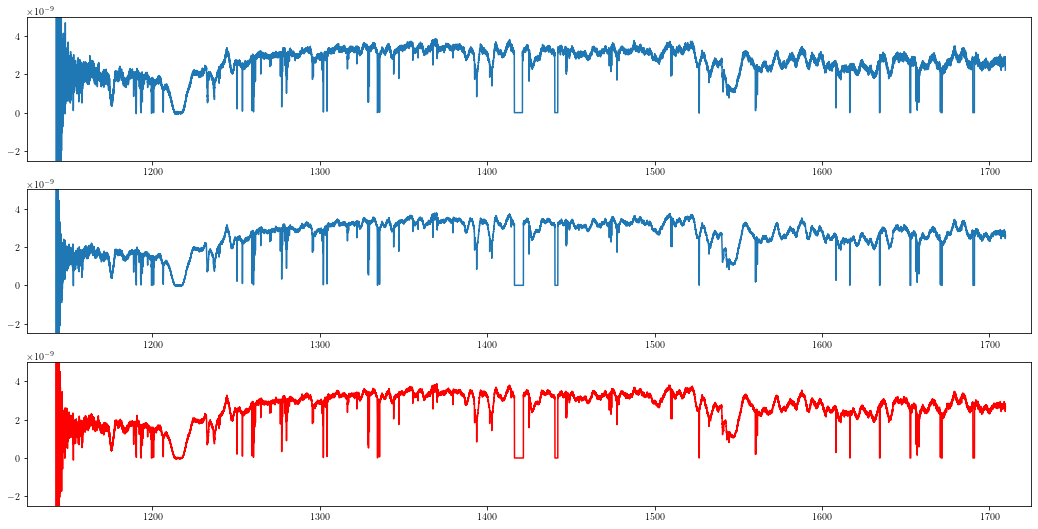

In [4]:
# 4

# Plot the two visit-level co-adds and the program-level co-add,
# and determine what base-level constituents make them up.

plt.figure(figsize=(18,9))

ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

# visit-level co-adds

table1 = fits.open(coadd_path+zetaoph_STIS_E140M_const_file1)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1)

hdul_1 = fits.open(coadd_path+zetaoph_STIS_E140M_const_file1)
x1d_data1 = hdul_1[1].data
x1d_head1 = hdul_1[0].data

x1d_flux1 = x1d_data1['FLUX']
x1d_wave1 = x1d_data1['WAVELENGTH']
x1d_err1 = x1d_data1['ERROR']

coadd_prov = hdul_1[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for zetaoph_1: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

table2 = fits.open(coadd_path+zetaoph_STIS_E140M_const_file2)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2)

hdul_2 = fits.open(coadd_path+zetaoph_STIS_E140M_const_file2)
x1d_data2 = hdul_2[1].data
x1d_head2 = hdul_2[0].data

x1d_flux2 = x1d_data2['FLUX']
x1d_wave2 = x1d_data2['WAVELENGTH']
x1d_err2 = x1d_data2['ERROR']

coadd_prov = hdul_2[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for zetaoph_2: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

# program-level co-add

table3 = fits.open(coadd_path+zetaoph_coadd_file)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3, color='red')

hdul_3 = fits.open(coadd_path+zetaoph_coadd_file)
x1d_data3 = hdul_3[1].data
x1d_head3 = hdul_3[0].data

x1d_flux3 = x1d_data3['FLUX']
x1d_wave3 = x1d_data3['WAVELENGTH']
x1d_err3 = x1d_data3['ERROR']

coadd_prov = hdul_3[2].data
coadd_files = coadd_prov['FILENAME'] 
print('These are the constituent files for zetaoph: ',coadd_files)
print('')
print('Number of co-add files: ', len(coadd_files))
print('')

# Set appropriate scales.

ax1.set_xlim(1125, 1725)
ax1.set_ylim(-2.5e-9, 5.0e-9)

ax2.set_xlim(1125, 1725)
ax2.set_ylim(-2.5e-9, 5.0e-9)

ax3.set_xlim(1125, 1725)
ax3.set_ylim(-2.5e-9, 5.0e-9)


In [5]:
# 5

# As we learned in the last cell, the first visit-level co-add
# is made up of only three base-level constituent spectra, while
# the second visit-level co-add is made up eleven.
#
# The overall program-level co-add is made up of seven base-level
# constituent spectra, so at some point four of these were rejected.
#
# Further note that, like we saw with PID 14781, the names of the
# files of the base-level constituent spectra are getting repeated.
#
# The first visit-level co-add is made up of a single base-level
# constituent spectrum repeated three times, while the second
# visit-level co-add is made up of three base-level constituent
# spectra, repeated three, four, and four times, respectively.
#
# The program-level co-added spectrum is made up of seven files, but
# in reality it's one file three times and a second file four times.

# zetaoph_1:  ['oe8s01010_x1d.fits' 'oe8s01010_x1d.fits' 'oe8s01010_x1d.fits']

# zetaoph_2:  ['oe8s04010_x1d.fits' 'oe8s04010_x1d.fits' 'oe8s04010_x1d.fits'
#              'oe8s04020_x1d.fits' 'oe8s04020_x1d.fits' 'oe8s04020_x1d.fits' 'oe8s04020_x1d.fits'
#              'oe8s04030_x1d.fits' 'oe8s04030_x1d.fits' 'oe8s04030_x1d.fits' 'oe8s04030_x1d.fits']

# zetaoph:    ['oe8s04010_x1d.fits' 'oe8s04010_x1d.fits' 'oe8s04010_x1d.fits'
#              'oe8s04030_x1d.fits' 'oe8s04030_x1d.fits' 'oe8s04030_x1d.fits' 'oe8s04030_x1d.fits']


In [6]:
# 6

# Let's take a look at the base-level STIS constituent spectra.

base_path = '/ifs/archive/dev/processing/hla/home/mburger/hasp/results_2023-09-14/16060/'

zetaoph_STIS_E140M_base_file01 = 'oe8s01010_x1d.fits'
zetaoph_STIS_E140M_base_file02 = 'oe8s01020_x1d.fits'
zetaoph_STIS_E140M_base_file03 = 'oe8s01030_x1d.fits'
zetaoph_STIS_E140M_base_file04 = 'oe8s01040_x1d.fits'
zetaoph_STIS_E140M_base_file05 = 'oe8s01050_x1d.fits'

zetaoph_STIS_E140M_base_file06 = 'oe8s03010_x1d.fits'
zetaoph_STIS_E140M_base_file07 = 'oe8s03020_x1d.fits'
zetaoph_STIS_E140M_base_file08 = 'oe8s03030_x1d.fits'
zetaoph_STIS_E140M_base_file09 = 'oe8s03040_x1d.fits'
zetaoph_STIS_E140M_base_file10 = 'oe8s03050_x1d.fits'

zetaoph_STIS_E140M_base_file11 = 'oe8s04010_x1d.fits'
zetaoph_STIS_E140M_base_file12 = 'oe8s04020_x1d.fits'
zetaoph_STIS_E140M_base_file13 = 'oe8s04030_x1d.fits'

# Of these thirteen base-level constituent files, only four
# are actually used in any of the co-added spectra:
# 01, 11, 12, and 13.
#
# I included all of them here so I could investigate why these
# other nine base-level constituent spectra were not included.
#
# First thing, though, is to compare the base-level constituents
# that actually are used against their visit-level co-adds.


(-2.5e-09, 5e-09)

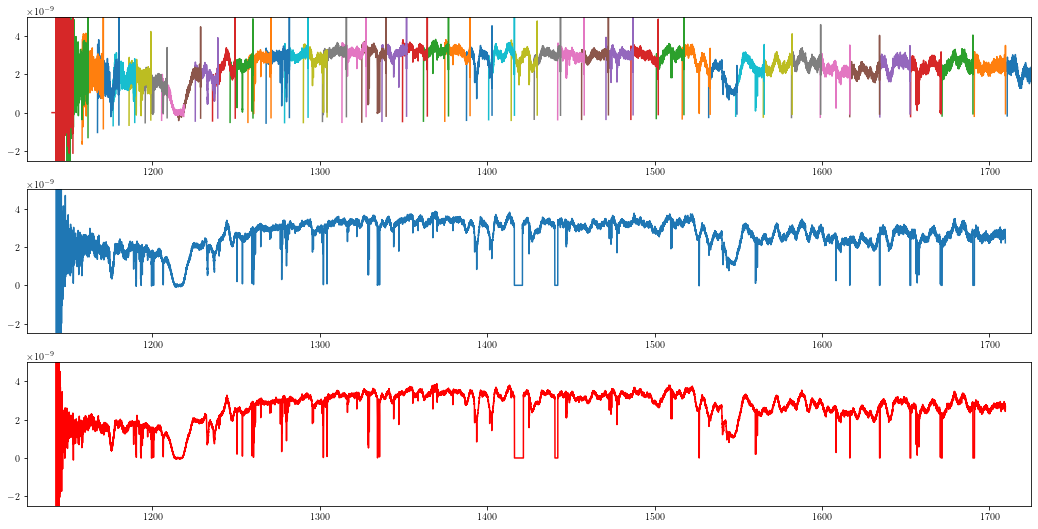

In [7]:
# 7

# Let's plot the single base-level constituent spectrum for
# the first visit-level co-added spectrum against the co-add
# itself (it should look the same, minus maybe a wavelength cut),
# and then against the overall program-level co-add.

plt.figure(figsize=(18,9))

ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

table1 = fits.open(base_path+zetaoph_STIS_E140M_base_file01)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1)

table2 = fits.open(coadd_path+zetaoph_STIS_E140M_const_file1)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2)

table3 = fits.open(coadd_path+zetaoph_coadd_file)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3, color='red')

# Set appropriate scales.

ax1.set_xlim(1125, 1725)
ax1.set_ylim(-2.5e-9, 5.0e-9)

ax2.set_xlim(1125, 1725)
ax2.set_ylim(-2.5e-9, 5.0e-9)

ax3.set_xlim(1125, 1725)
ax3.set_ylim(-2.5e-9, 5.0e-9)


(-2.5e-09, 5e-09)

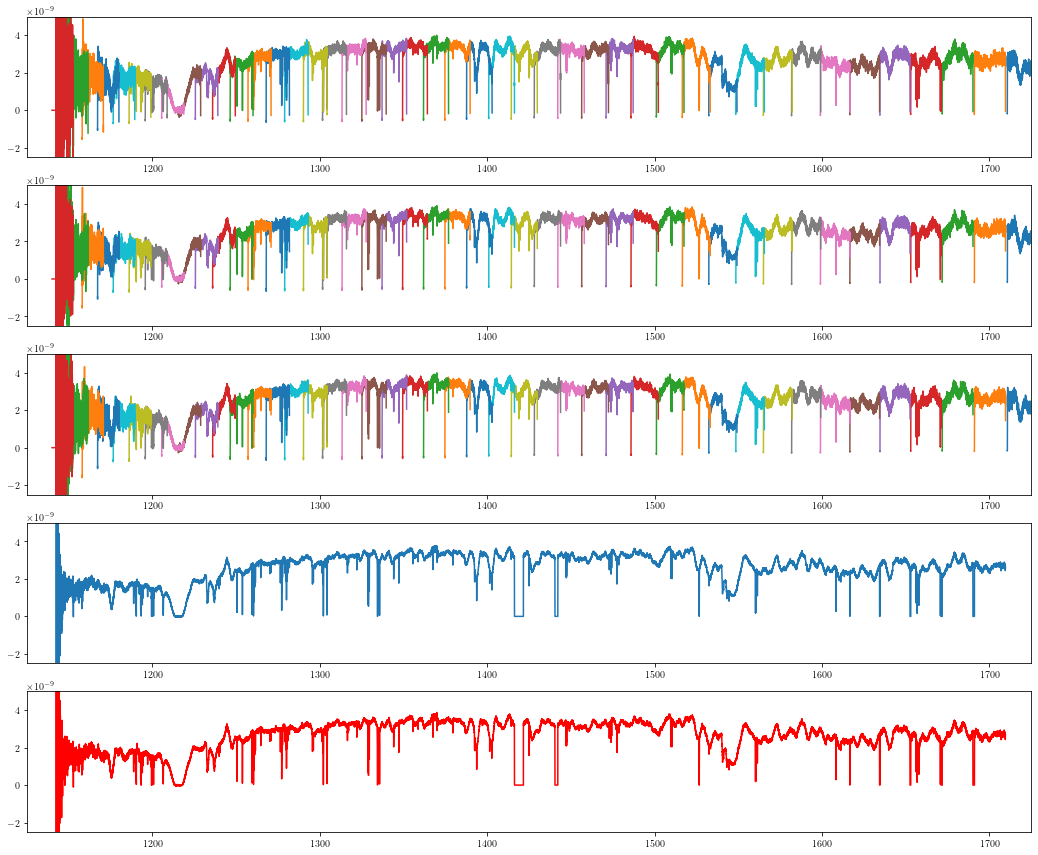

In [8]:
# 8

# Let's plot the three base-level constituent spectra for
# the second visit-level co-added spectrum against the co-add
# itself, and then against the overall program-level co-add.

plt.figure(figsize=(18,15))

ax1 = plt.subplot(511)
ax2 = plt.subplot(512)
ax3 = plt.subplot(513)
ax4 = plt.subplot(514)
ax5 = plt.subplot(515)

table1 = fits.open(base_path+zetaoph_STIS_E140M_base_file11)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1)

table2 = fits.open(base_path+zetaoph_STIS_E140M_base_file12)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2)

table3 = fits.open(base_path+zetaoph_STIS_E140M_base_file13)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3)

table4 = fits.open(coadd_path+zetaoph_STIS_E140M_const_file2)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(coadd_path+zetaoph_coadd_file)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5, color='red')

# Set appropriate scales.

ax1.set_xlim(1125, 1725)
ax1.set_ylim(-2.5e-9, 5.0e-9)

ax2.set_xlim(1125, 1725)
ax2.set_ylim(-2.5e-9, 5.0e-9)

ax3.set_xlim(1125, 1725)
ax3.set_ylim(-2.5e-9, 5.0e-9)

ax4.set_xlim(1125, 1725)
ax4.set_ylim(-2.5e-9, 5.0e-9)

ax5.set_xlim(1125, 1725)
ax5.set_ylim(-2.5e-9, 5.0e-9)


(-2.5e-09, 5e-09)

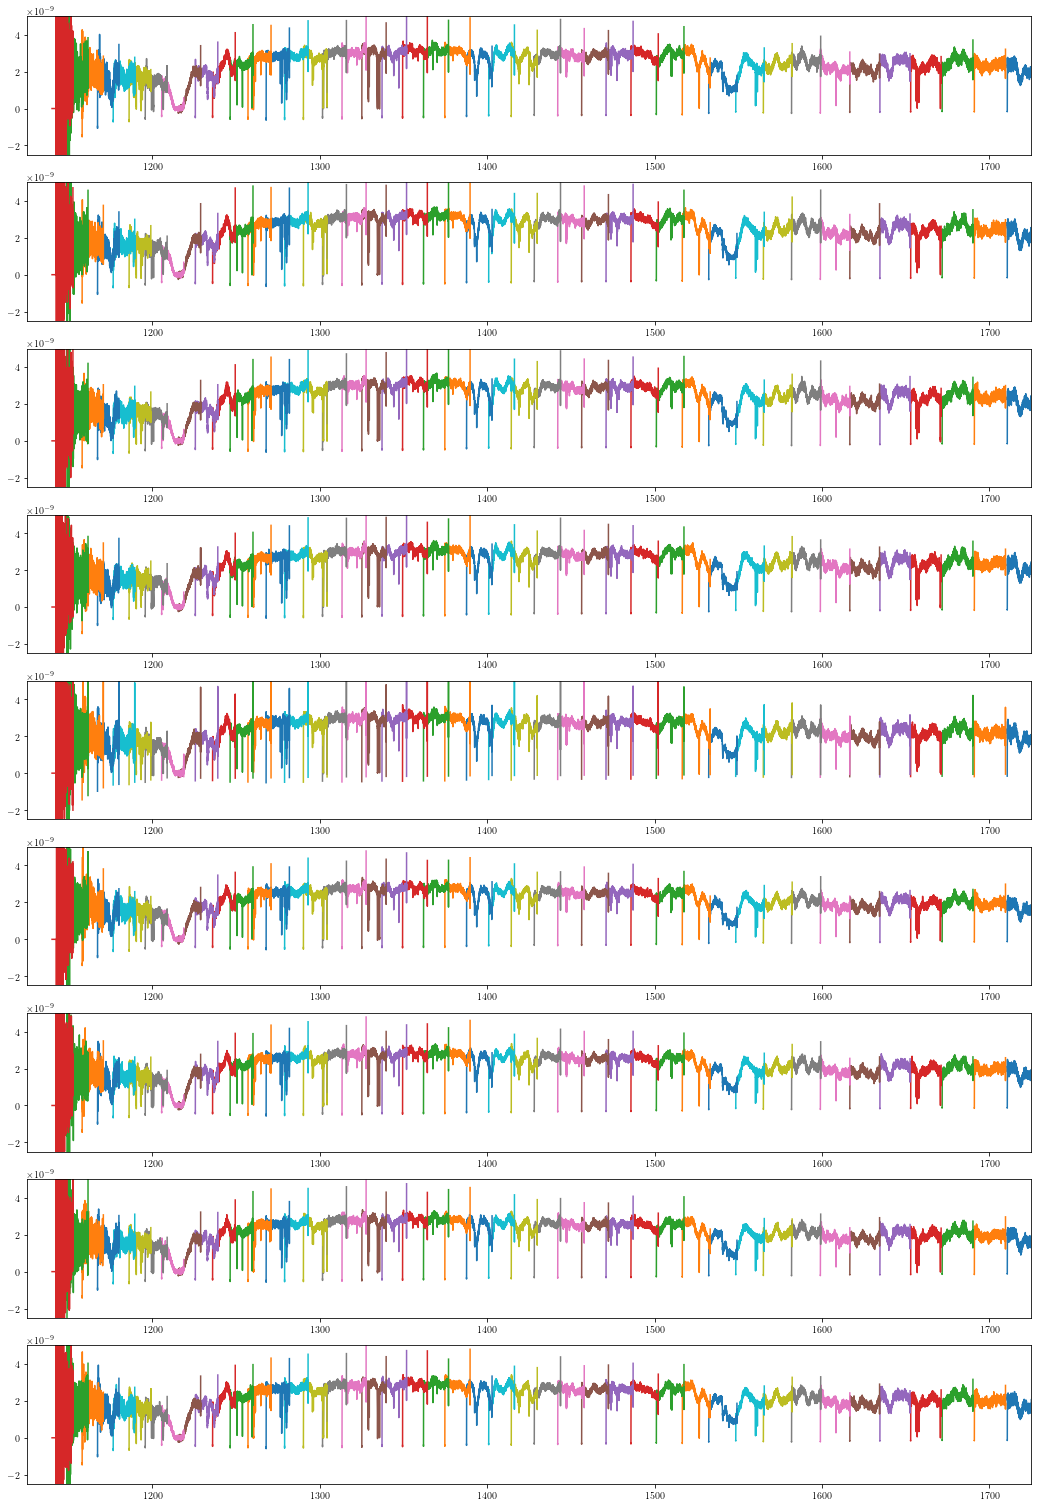

In [9]:
# 9

# Now for my own interest, let's look at the other
# nine unused base-level constituent spectra.

plt.figure(figsize=(18,27))

ax1 = plt.subplot(911)
ax2 = plt.subplot(912)
ax3 = plt.subplot(913)
ax4 = plt.subplot(914)
ax5 = plt.subplot(915)
ax6 = plt.subplot(916)
ax7 = plt.subplot(917)
ax8 = plt.subplot(918)
ax9 = plt.subplot(919)

table1 = fits.open(base_path+zetaoph_STIS_E140M_base_file02)[1].data
for row in table1:
    wave1 = row['wavelength']
    flux1 = row['flux']
    ax1.plot(wave1,flux1)

table2 = fits.open(base_path+zetaoph_STIS_E140M_base_file03)[1].data
for row in table2:
    wave2 = row['wavelength']
    flux2 = row['flux']
    ax2.plot(wave2,flux2)

table3 = fits.open(base_path+zetaoph_STIS_E140M_base_file04)[1].data
for row in table3:
    wave3 = row['wavelength']
    flux3 = row['flux']
    ax3.plot(wave3,flux3)

table4 = fits.open(base_path+zetaoph_STIS_E140M_base_file05)[1].data
for row in table4:
    wave4 = row['wavelength']
    flux4 = row['flux']
    ax4.plot(wave4,flux4)

table5 = fits.open(base_path+zetaoph_STIS_E140M_base_file06)[1].data
for row in table5:
    wave5 = row['wavelength']
    flux5 = row['flux']
    ax5.plot(wave5,flux5)

table6 = fits.open(base_path+zetaoph_STIS_E140M_base_file07)[1].data
for row in table6:
    wave6 = row['wavelength']
    flux6 = row['flux']
    ax6.plot(wave6,flux6)

table7 = fits.open(base_path+zetaoph_STIS_E140M_base_file08)[1].data
for row in table7:
    wave7 = row['wavelength']
    flux7 = row['flux']
    ax7.plot(wave7,flux7)

table8 = fits.open(base_path+zetaoph_STIS_E140M_base_file09)[1].data
for row in table8:
    wave8 = row['wavelength']
    flux8 = row['flux']
    ax8.plot(wave8,flux8)

table9 = fits.open(base_path+zetaoph_STIS_E140M_base_file10)[1].data
for row in table9:
    wave9 = row['wavelength']
    flux9 = row['flux']
    ax9.plot(wave9,flux9)

# Set appropriate scales.

ax1.set_xlim(1125, 1725)
ax1.set_ylim(-2.5e-9, 5.0e-9)

ax2.set_xlim(1125, 1725)
ax2.set_ylim(-2.5e-9, 5.0e-9)

ax3.set_xlim(1125, 1725)
ax3.set_ylim(-2.5e-9, 5.0e-9)

ax4.set_xlim(1125, 1725)
ax4.set_ylim(-2.5e-9, 5.0e-9)

ax5.set_xlim(1125, 1725)
ax5.set_ylim(-2.5e-9, 5.0e-9)

ax6.set_xlim(1125, 1725)
ax6.set_ylim(-2.5e-9, 5.0e-9)

ax7.set_xlim(1125, 1725)
ax7.set_ylim(-2.5e-9, 5.0e-9)

ax8.set_xlim(1125, 1725)
ax8.set_ylim(-2.5e-9, 5.0e-9)

ax9.set_xlim(1125, 1725)
ax9.set_ylim(-2.5e-9, 5.0e-9)
